Improvements over binary classifier:

- removed unused graphviz import
- define labels to classify: simply encode (no) vandalism according to a set of labels
- use features computed by rev 5f03bf5 of the vandalism detector, includes revision ID
- use DataFrame - it works the same and retains column labels etc.
- added plt.show() to error analysis to draw matrix
- add example FP and FN (= misclassified revisions)
- added plot for FP frequency per tag


In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc, precision_recall_curve, confusion_matrix, average_precision_score
from sklearn.pipeline import Pipeline

In [58]:
# Import dataset
df = pd.read_csv('./data/features-modified-total-5f03bf5.csv')
tag_df = pd.read_csv('./data/tag.csv')
labels = df.columns
df.head()

,currentRowCount,currentColumnCount,currentCellCount,unmatchedTableRatio,unmatchedRowRatio,isContributorAnonymous,timeOfDay,dayOfWeek,isMinorEdit,commentLength,...,previousLength,offensiveWordCountInTables,offensiveWordCountInComment,averageRelativeFrequencyOfNewAddedWords,LZWCompressionRate,KLDOfCharDistribution,isCommentDeleted,isContributorDeleted,revision_id,tag_id
0,7,6,42,1.0,0.285714,0,2,2,0,14,...,8160,10,0,1.222222,0.335988,315.482353,0,0,730449352,12
1,6,2,12,1.0,0.000000,0,20,3,0,16,...,3531,2,0,1.000000,0.516629,782.615290,0,0,483213111,2
2,6,2,12,1.0,0.000000,0,20,3,0,16,...,3531,2,0,1.000000,0.516629,782.615290,0,0,483213111,11
3,0,0,0,1.0,1.000000,0,17,6,1,67,...,1629,0,0,1.000000,0.588710,827.648471,0,0,216224416,12
4,0,0,0,1.0,1.000000,0,1,4,1,152,...,12135,5,0,1.000000,0.445522,8321.063893,0,0,539338621,12


In [59]:
# Encode vandalism or no vandalism according to tags-of-interest
TAG_IDS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
df['is_vandalism'] = df.tag_id.isin(TAG_IDS)

In [60]:
# Convert from pandas to numpy arrays
X = df.drop(['tag_id', 'is_vandalism'], axis=1)
y = df['is_vandalism']
labels = X.columns

In [61]:
# Split dataset into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y)

print('Train X', X_train.shape)
print('Train y', y_train.shape)

print('Test X', X_test.shape)
print('Test y', y_test.shape)

Train X (2775, 38)
Train y (2775,)
Test X (926, 38)
Test y (926,)


In [62]:
# Build model and evaluate parameters using crossvalidation
clf = RandomForestClassifier(class_weight='balanced')

scores = cross_validate(clf, X_train, y_train,
                        scoring=['f1', 'precision', 'recall', 'roc_auc', 'accuracy'],
                        cv=3, return_train_score=False)    

print('Training scores:')
for name, values in scores.items():
    print(name, ": %0.2f (+/- %0.2f)" % (values.mean(), values.std() * 2))

Training scores:
fit_time : 0.11 (+/- 0.08)
score_time : 0.03 (+/- 0.02)
test_f1 : 0.71 (+/- 0.01)
test_precision : 0.75 (+/- 0.02)
test_recall : 0.67 (+/- 0.03)
test_roc_auc : 0.84 (+/- 0.01)
test_accuracy : 0.76 (+/- 0.00)


In [63]:
# Evaluate model parameters: Confusion matrix
columns = ['Predicted No Vandalism', 'Predicted Vandalism']
index = ['True No Vandalism', 'True Vandalism']
classes = ['No Vandalism', 'Vandalism']

y_train_predict = cross_val_predict(clf, X_train, y_train, cv=3)
cf_matrix = confusion_matrix(y_train, y_train_predict)

print('Training scores:')
pd.DataFrame(cf_matrix, columns=columns, index=index)

Training scores:


,Predicted No Vandalism,Predicted Vandalism
True No Vandalism,1317,262
True Vandalism,413,783


In [64]:
# Evaluate model parameters: Classification report
print('Training scores:')
print(classification_report(y_train, y_train_predict, target_names=classes))

Training scores:
              precision    recall  f1-score   support

No Vandalism       0.76      0.83      0.80      1579
   Vandalism       0.75      0.65      0.70      1196

 avg / total       0.76      0.76      0.75      2775



In [65]:
# Train model
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
y_predict_prob = clf.predict_proba(X_test)
y_predict_vandalism = y_predict_prob[:,1]

Precision and recall scores:


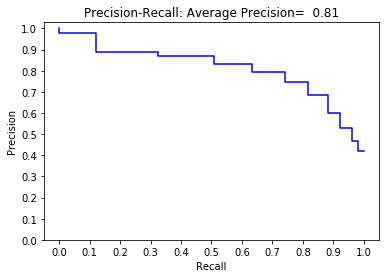

In [66]:
# Evaluate model: Precision & Recall
print('Precision and recall scores:')

precision, recall, thresholds = precision_recall_curve(y_test, y_predict_vandalism)
average_precision = average_precision_score(y_test, y_predict_vandalism)

plt.title('Precision-Recall: Average Precision=  %0.2f' % average_precision)
plt.step(recall, precision, color='b', where='post')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [67]:
# Evaluate model: Confusion matrix
columns = ['Predicted No Vandalism', 'Predicted Vandalism']
index = ['True No Vandalism', 'True Vandalism']

print('Final model scores:')
pd.DataFrame(confusion_matrix(y_test, y_predict), columns=columns, index=index)

Final model scores:


,Predicted No Vandalism,Predicted Vandalism
True No Vandalism,461,75
True Vandalism,101,289


In [68]:
# Evaluate model: Classification report
print('Final model scores:')
print(classification_report(y_test, y_predict, target_names=classes))

Final model scores:
              precision    recall  f1-score   support

No Vandalism       0.82      0.86      0.84       536
   Vandalism       0.79      0.74      0.77       390

 avg / total       0.81      0.81      0.81       926



Final model scores:
roc_auc 0.8699746460007654


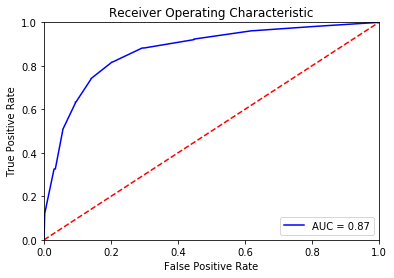

In [69]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_predict_vandalism)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('Final model scores:')
print('roc_auc', roc_auc)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

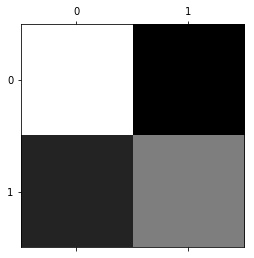

In [70]:
# Error analysis
y_train_predict = cross_val_predict(clf, X_train, y_train, cv=3)
cf_matrix = confusion_matrix(y_train, y_train_predict)

plt.matshow(cf_matrix, cmap=plt.cm.gray)
plt.show()

In [71]:
# Showing some instances not classifed correctly

# False Negatives for the test set
fn_test = X_test[(y_test == 1) & (y_predict == 0)]
fn_merged = fn_test.merge(df, how='left', on='revision_id')
fn_merged.merge(tag_df, how='left', left_on='tag_id', right_on='id')[['revision_id', 'tag_id', 'name']]

,revision_id,tag_id,name
0,688616436,6,Syntax
1,531438560,5,FalseFacts
2,531438560,11,Intention
3,215193336,5,FalseFacts
4,215193336,11,Intention
5,214161147,2,Nonsense
6,702110643,5,FalseFacts
7,702110643,11,Intention
8,136706306,5,FalseFacts
9,526662452,5,FalseFacts


In [72]:
# False Positives for the test set
fp_test = X_test[(y_test == 0) & (y_predict == 1)]
fp_merged = fp_test.merge(df, how='left', on='revision_id')
fp_with_labels = fp_merged.merge(tag_df, how='left', left_on='tag_id', right_on='id') \
    [['revision_id', 'tag_id', 'name']]
fp_with_labels

,revision_id,tag_id,name
0,58363091,12,constructive
1,172750743,12,constructive
2,254289420,1,Blanking
3,254289420,12,constructive
4,769201226,12,constructive
5,86750105,9,EditWars
6,86750105,12,constructive
7,342242132,12,constructive
8,342249160,12,constructive
9,443540508,12,constructive


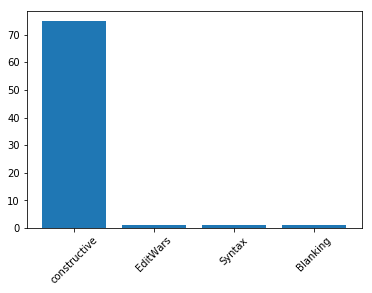

In [73]:
fp_tag_counts = fp_with_labels.name.value_counts()
tag_x = np.arange(len(fp_tag_counts))
plt.bar(tag_x, fp_tag_counts.values)
plt.xticks(tag_x, fp_tag_counts.index, rotation=45)
plt.show()

In [74]:
fp_with_labels[fp_with_labels.name == 'FalseFacts']

,revision_id,tag_id,name


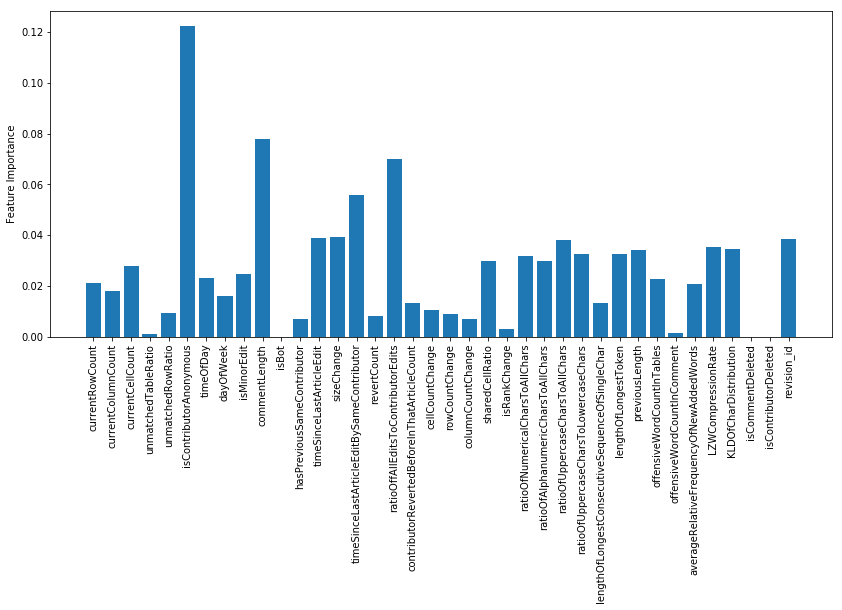

In [75]:
# Feature importance (weights in random forrest)
feature_importance = clf.feature_importances_
feature_labels = labels
x_pos = np.arange(len(feature_importance)) 

plt.gcf().set_size_inches(14, 6)
plt.bar(x_pos, feature_importance,align='center')
plt.xticks(x_pos, feature_labels, rotation='vertical') 
plt.ylabel('Feature Importance')
plt.show()